In [84]:
# import what we need
import nltk
from nltk.stem.lancaster import LancasterStemmer ## used to stem words
import tensorflow
import random
import json # used to read in json file
stemmer = LancasterStemmer()

import numpy as np
import tensorflow.keras as keras

# printing 
from IPython.display import display
import sympy as sp
sp.init_printing(use_latex=True)

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline


In [85]:
# load json file
with open("intents.json") as file:
    data = json.load(file)

In [86]:
# view our json data
data['intents']

[{'tag': 'greeting',
  'patterns': ['Hi',
   'How are you',
   'Is anyone there?',
   'Hello',
   'Good day',
   'Whats up'],
  'responses': ['Hello!',
   'Good to see you again!',
   'Hi there, how can I help?'],
  'context_set': ''},
 {'tag': 'goodbye',
  'patterns': ['cya',
   'See you later',
   'Goodbye',
   'I am Leaving',
   'Have a Good day'],
  'responses': ['Sad to see you go :(', 'Talk to you later', 'Goodbye!'],
  'context_set': ''},
 {'tag': 'age',
  'patterns': ['how old',
   'how old is tim',
   'what is your age',
   'how old are you',
   'age?'],
  'responses': ['I am 18 years old!', '18 years young!'],
  'context_set': ''},
 {'tag': 'name',
  'patterns': ['what is your name',
   'what should I call you',
   'whats your name?'],
  'responses': ['You can call me Tim.',
   "I'm Tim!",
   "I'm Tim aka Tech With Tim."],
  'context_set': ''},
 {'tag': 'shop',
  'patterns': ['Id like to buy something',
   'whats on the menu',
   'what do you reccommend?',
   'could i get som

In [87]:
words = []
labels = []

docs_x = []
docs_y = [] 

# loop through dict to grab our values
for intent in data['intents']:
    for pattern in intent['patterns']:
        # stemming get the root of word, when traiing model 
        # only care abt the main meaning of word
        # need to tokenize/split words
        wrds = nltk.word_tokenize(pattern)
        words.extend(wrds) ## add all wrds to list
        docs_x.append(wrds)
        # for each pattern add another item in this var to track what tag its part of
        # each entry in docs_x (tokenized words/wrds) will correspond to (intent) docs_y so we know how to classify
        # each of the patterns
        docs_y.append(intent['tag'])
        
        if intent['tag'] not in labels:
            labels.append(intent['tag']) # grab all diff tags we need

In [88]:
# stem words and remove duplicate words. also lower all words so dont confuse the network into 
# thinking spelling case has different meaning
words = [stemmer.stem(w.lower()) for w in words if w!= '?' ] # remove any Question marks, dont want this
words = sorted(list(set(words)))                             # to have any meaning to our model
# sort the labels also 
labels = sorted(labels)

In [89]:
# prepare data before we feed into the model 

# need to convert our text in lists to nums (One-hot-encoding) so our network can 
# categorize the data
training = [] # input data goes here 
output = [] 

out_empty = [0 for _ in range(len(labels))]

for x, doc in enumerate(docs_x):
    
    bag = [] # will be our bag of one hot encoded words
    wrds = [stemmer.stem(w) for w in doc] # stem all the words in patterns
    
    # go through all diff words in list that are stemmed
    # and add either 1 or 0 to bag of words depending on if this word is in the 
    # main words list "(words = sorted(list(set(words))))"
    for w in words:
        # if word here place 1 representing that word exists
        if w in wrds:
            bag.append(1)
        else:
            # word isn't here place 0
            bag.append(0)
    
    # now generate output that has either 0's or 1's representing the tag that is word
    output_row = out_empty[:]
    # will look through labels list and check where tag is in list and set that value to 1 
    # in the output_row 
    output_row[labels.index(docs_y[x])] = 1
    
    # now we have both lists that are now One-hot-encoded !!
    training.append(bag)
    output.append(output_row)


In [90]:
# turn lists into numpy array
training = np.array(training)
output = np.array(output)


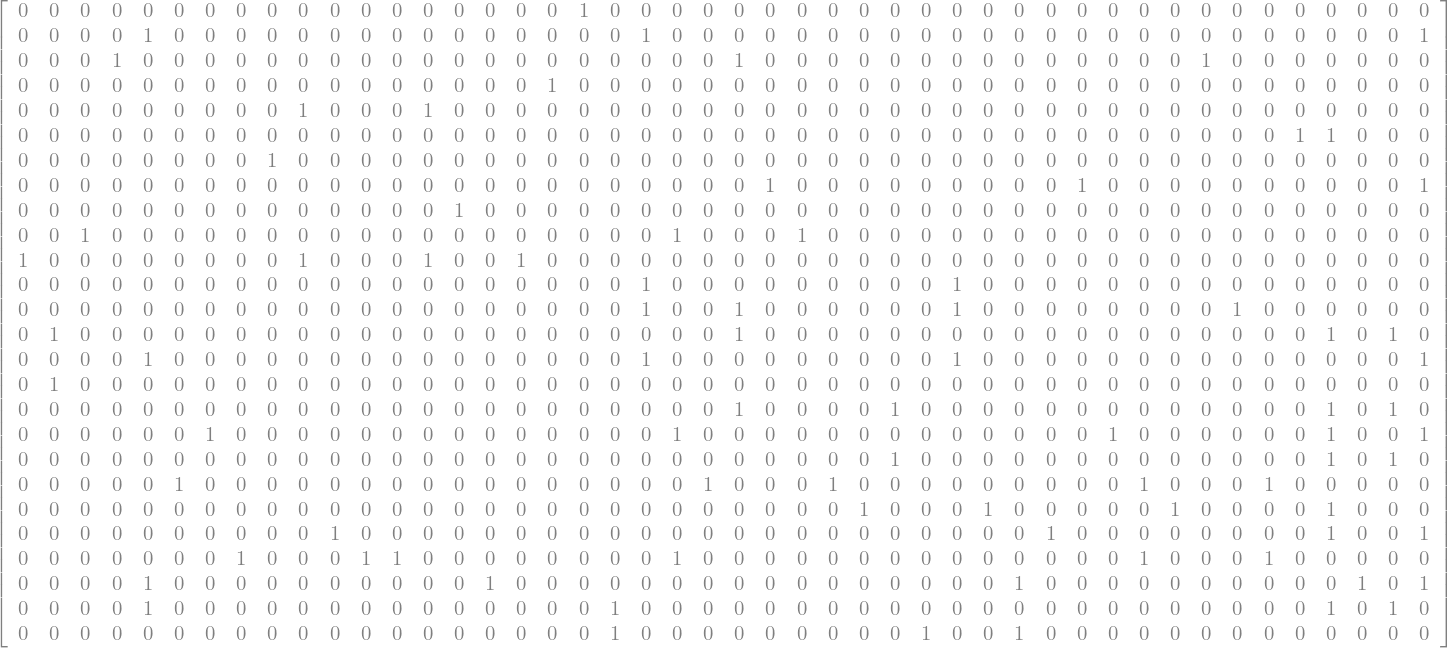

In [75]:
display(sp.Matrix(training))

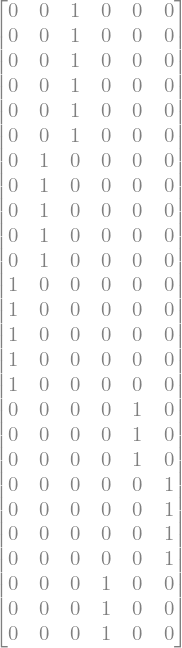

In [76]:
display(sp.Matrix(output))

In [95]:
# Multi-layer net with ReLU hidden layer

model = keras.models.Sequential()


model.add(keras.layers.Dense(3,input_dim=46,activation='relu',
 bias_initializer=keras.initializers.Constant(0.1)))

# Output layer (size 6), softmax activation function
model.add(keras.layers.Dense(6,activation='softmax'))

In [96]:
# Compile as above (default learning rate and other
# hyperparameters for the Adam optimizer).
# default learning rate for adam optimizer is 0.001

model.compile(loss=keras.losses.CategoricalCrossentropy(),
 optimizer=keras.optimizers.Nadam(learning_rate=0.01),
  metrics=[keras.metrics.BinaryAccuracy()]            )

# Display the model
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 3)                 141       
_________________________________________________________________
dense_16 (Dense)             (None, 6)                 24        
Total params: 165
Trainable params: 165
Non-trainable params: 0
_________________________________________________________________


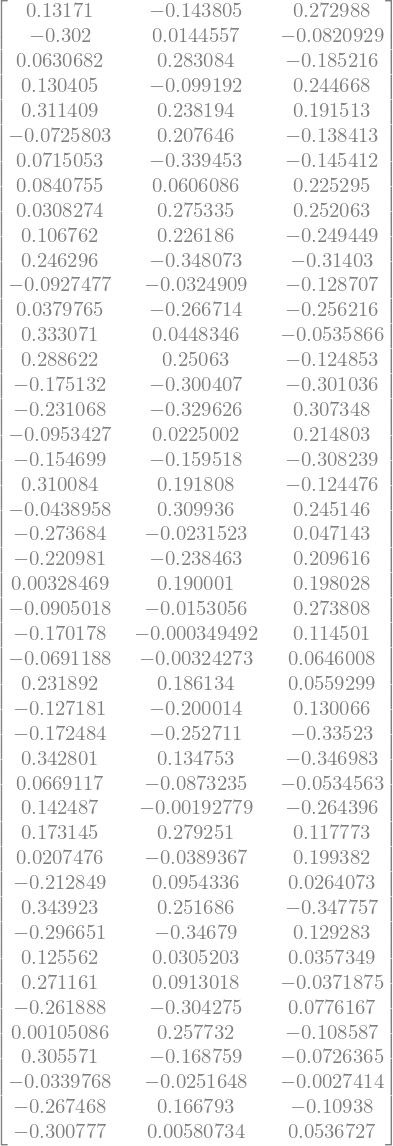

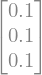

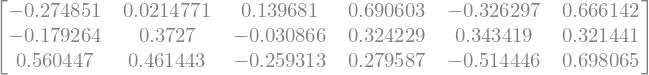

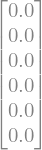

In [97]:
# Note the initializer for the hidden unit bias weights
for i in model.get_weights():
 display(sp.Matrix(i))


In [98]:
# Train it!
history = model.fit(training, output,
 batch_size=1,
 epochs=300,
 verbose=0)

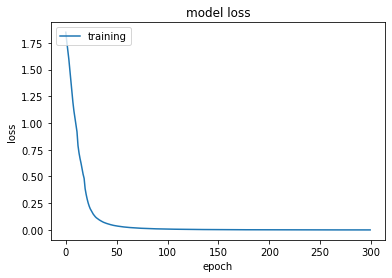

In [99]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training'], loc='upper left')
plt.show()

In [102]:
score = model.evaluate(training,output,verbose=1)
print("Loss:",score[0])
print("Accuracy:",score[1])

Loss: 0.00031563028460368514
Accuracy: 1.0


In [101]:
# save the model .. comment out for now until we train the data appropriately
# model.save("model.Chatbot")